In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')

#from google.colab import drive
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import cohen_kappa_score, classification_report
import numpy as np

#drive.mount('/content/gdrive')

file_path_test = '/kaggle/input/train-test/test.csv'
file_path_train = '/kaggle/input/train-test/train.csv'

test = pd.read_csv(file_path_test)
train = pd.read_csv(file_path_train)

/tmp/ipykernel_34/1008475701.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [2]:
test

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [3]:
train

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


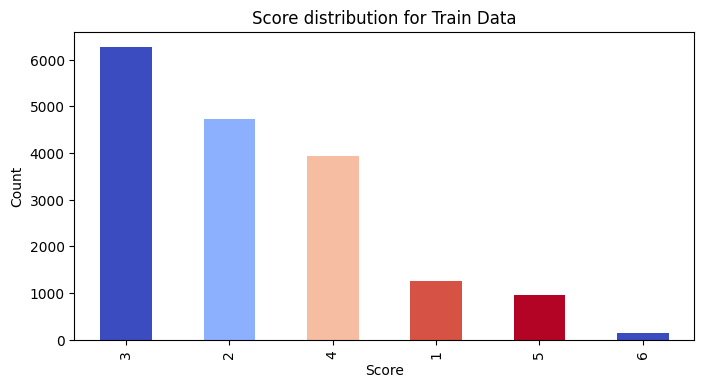

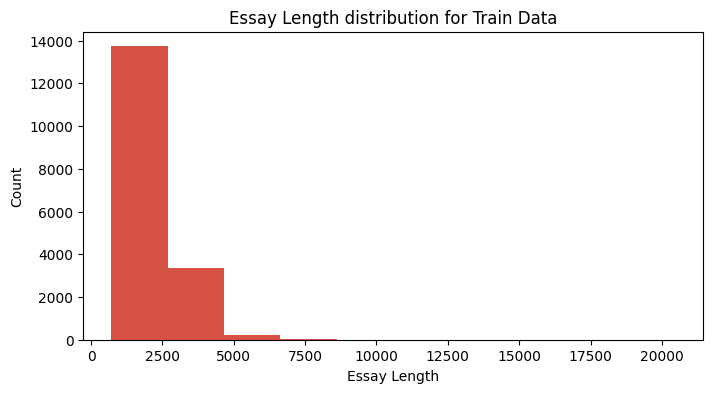

In [4]:
plt.figure(figsize=(8, 4))
train.score.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score distribution for Train Data")
plt.show()

# Show distribution of essay length using a bar plot
plt.figure(figsize=(8, 4))
train['essay_length'] = train.full_text.map(len)
train.essay_length.plot.hist(logy=False, color=cmap(0.9))
plt.xlabel("Essay Length")
plt.ylabel("Count")
plt.title("Essay Length distribution for Train Data")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

train['score'] = train['score'] - 1
X = train['full_text']
y = train['score']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train[:5000]
y_train = y_train[:5000]
X_val = X_val[:5000]
y_val = y_val[:5000]

In [6]:
from transformers import BertTokenizer

# Charger le tokenizer pré-entraîné
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizer les textes
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=512)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
import torch

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EssayDataset(train_encodings, y_train.tolist())
val_dataset = EssayDataset(val_encodings, y_val.tolist())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)


In [8]:
# Convertir en tensors
train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(y_train.values)

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_masks = torch.tensor(val_encodings['attention_mask'])
val_labels = torch.tensor(y_val.values)

In [9]:
from transformers import BertForSequenceClassification, AdamW

# Charger le modèle pré-entraîné
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Définir l'optimiseur
optimizer = AdamW(model.parameters(), lr=5e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
from transformers import get_linear_schedule_with_warmup


# Scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
num_epochs = 3
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop with early stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, min_delta=0.001)


In [11]:
def quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculates the quadratic weighted kappa
    """
    min_rating = min(min(y_true), min(y_pred))
    max_rating = max(max(y_true), max(y_pred))
    num_ratings = int(max_rating - min_rating + 1)

    conf_matrix = np.zeros((num_ratings, num_ratings), dtype=np.float64)
    for a, b in zip(y_true, y_pred):
        conf_matrix[a - min_rating][b - min_rating] += 1

    num_scored_items = float(len(y_true))

    hist_true = np.zeros(num_ratings)
    hist_pred = np.zeros(num_ratings)

    for i in range(num_ratings):
        hist_true[i] = sum(conf_matrix[i, :])
        hist_pred[i] = sum(conf_matrix[:, i])

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_true[i] * hist_pred[j] / num_scored_items)
            d = float((i - j) ** 2) / (num_ratings - 1) ** 2
            numerator += d * conf_matrix[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


In [12]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device, dtype=torch.long)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}')

    # Validation step
    model.eval()
    val_loss = 0
    val_labels_list = []
    val_preds_list = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device, dtype=torch.long)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            val_preds_list.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    print(f'Validation Loss: {avg_val_loss}')

    # Calculate QWK using the dedicated function
    qwk = quadratic_weighted_kappa(val_labels_list, val_preds_list)
    print(f'Validation QWK: {qwk}')

    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 1/3, Training Loss: 1.1265675361156464
Validation Loss: 0.969499904825836
Validation QWK: 0.6968908106492713
Epoch 2/3, Training Loss: 0.8944561767578125
Validation Loss: 0.9308191857216815
Validation QWK: 0.7470870910748948
Epoch 3/3, Training Loss: 0.6507645667552948
Validation Loss: 0.9389363585113103
Validation QWK: 0.774858972227094


In [13]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Enregistrer le modèle et le tokenizer
model_save_path = '/kaggle/working/essay_scoring_model'
tokenizer_save_path = '/kaggle/working/tokenizer'

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('/kaggle/working/tokenizer/tokenizer_config.json',
 '/kaggle/working/tokenizer/special_tokens_map.json',
 '/kaggle/working/tokenizer/vocab.txt',
 '/kaggle/working/tokenizer/added_tokens.json')

In [14]:
model_save_path = '/kaggle/working/essay_scoring_model'
tokenizer_save_path = '/kaggle/working/tokenizer'

# Charger le modèle et le tokenizer
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(tokenizer_save_path)
model.to(device)

# Fonction pour prédire le score d'une phrase
def predict_score(sentence, model, tokenizer, device):
    model.eval()
    with torch.no_grad():
        # Prétraiter la phrase
        encoding = tokenizer(sentence, truncation=True, padding=True, max_length=512, return_tensors='pt')
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Faire la prédiction
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        return preds.item()

# Exemple d'utilisation pour prédire le score d'une nouvelle phrase
new_sentence = "This is an example essay to predict its score."
predicted_score = predict_score(new_sentence, model, tokenizer, device)
print(f'Predicted Score: {predicted_score}')


Predicted Score: 1


In [17]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Charger le modèle et le tokenizer
model_save_path = '/kaggle/working/essay_scoring_model'
tokenizer_save_path = '/kaggle/working/tokenizer'

model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(tokenizer_save_path)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Charger le dataset de test
#file_path_test = '/kaggle/working/test.csv'
test_df = test

# Fonction pour prédire le score d'une phrase
def predict_score(sentence, model, tokenizer, device):
    model.eval()
    with torch.no_grad():
        # Prétraiter la phrase
        encoding = tokenizer(sentence, truncation=True, padding=True, max_length=512, return_tensors='pt')
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Faire la prédiction
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        return preds.item()

# Prédire les scores pour chaque essai dans le jeu de données de test
test_df['score'] = test_df['full_text'].apply(lambda x: predict_score(x, model, tokenizer, device))

# Créer le fichier de soumission
submission_df = test_df[['essay_id', 'score']]
submission_file_path = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print("Submission file created successfully.")


Submission file created successfully.
